In [35]:
import numpy as np
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
import matplotlib_inline 
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split

from torch.utils.data import  DataLoader ,TensorDataset
import seaborn as sns

In [36]:
iris = sns.load_dataset("iris")

In [37]:
# convert pandas to tensor
data = torch.tensor(iris[iris.columns[0:4]].values, dtype=torch.float)

# label encoding
labels = torch.zeros(data.shape[0],dtype=torch.long)

labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [38]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

train_data = TensorDataset(torch.Tensor(train_data),torch.Tensor(train_labels))

test_data = TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels))

batchSize = 64
train_loader = DataLoader(train_data,shuffle=True,batch_size=batchSize,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [39]:
def createNet(L2lambda):
    
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )
    
    
    lossFn = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.005,weight_decay=L2lambda)
    
    return ANNiris,lossFn,optimizer

In [40]:

num_epochs = 1000

def trainNet():
    
    # init accurascies as empties
    trainAcc = []
    testAcc = []
    losses = []
    
    for epochI in range(num_epochs):
        
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            yHat = ANNiris(X)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            batchAcc.append(100*torch.mean((torch.argmax(yHat,dim=1) == y).float()).item())
            batchLoss.append(loss.item())
            
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        X,y = next(iter(test_loader))
        predLabels = torch.argmax(ANNiris(X),dim=1)
        testAcc.append(100*torch.mean((predLabels == y).float()).item())
        
            
    return trainAcc,testAcc,losses 

In [41]:

L2lambda = .01
ANNiris,lossFn,optimizer = createNet(L2lambda)

trainAcc,testAcc,losses = trainNet()

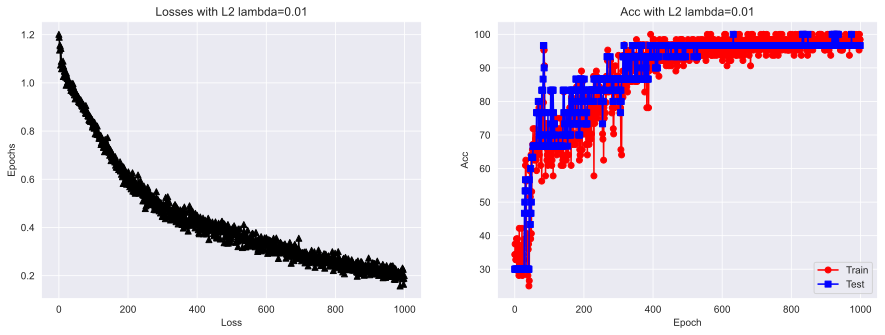

In [42]:
fig ,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(losses,'k^-')
ax[0].set_xlabel("Loss")
ax[0].set_ylabel("Epochs")
ax[0].set_title("Losses with L2 lambda=" + str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Acc")
ax[1].set_title("Acc with L2 lambda=" + str(L2lambda))
ax[1].legend(["Train","Test"])

plt.show()

In [43]:
def smooth(x,k):
    return np.convolve(x,np.ones(k)/k,mode='same')

### The experiment

In [44]:
l2lambdas = np.linspace(0,.1,10)

accResTrain = np.zeros((num_epochs,len(l2lambdas)))
accResTest = np.zeros((num_epochs,len(l2lambdas)))

for li in range(len(l2lambdas)):
    
    ANNiris,lossFn,optimizer = createNet(l2lambdas[li])
    trainAcc,testAcc,losses = trainNet()
    
    # store data
    accResTrain[:,li] = smooth(trainAcc,10)
    accResTest[:,li] = smooth(testAcc,10)

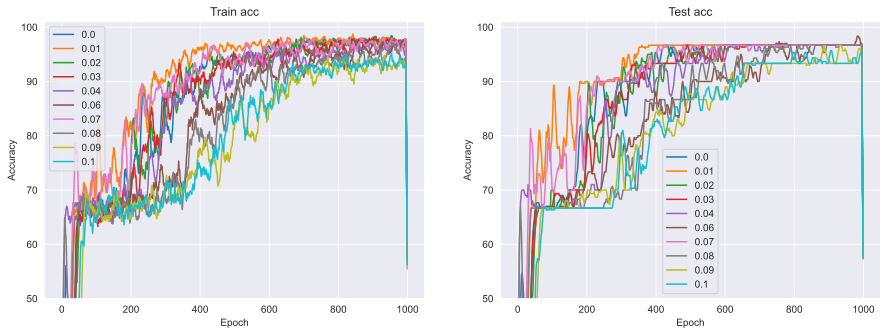

In [45]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(accResTrain)
ax[0].set_title("Train acc")
ax[1].plot(accResTest)
ax[1].set_title("Test acc")

legLabels = [np.round(i,2) for i in l2lambdas]

for i in range(2):
    ax[i].legend(legLabels)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy")
    ax[i].set_ylim([50,101])
    # ax[i].grid()
    
plt.show()

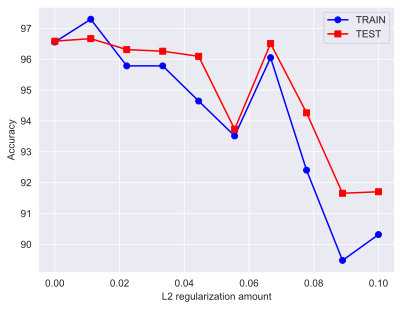

In [46]:
# show avarage acc by L2 rate

epoch_range = [500,950]

plt.plot(l2lambdas,
         np.mean(accResTrain[epoch_range[0]:epoch_range[1],:],axis=0),'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accResTest[epoch_range[0]:epoch_range[1],:],axis=0),'rs-',label='TEST')

plt.xlabel("L2 regularization amount")
plt.ylabel("Accuracy")
plt.legend()
plt.show()